In [1]:
from transduction.smc.smc import SMC, Particle, logsumexp
from transduction.smc.lm.aa import create_dna_translator, get_source_lm_probs, score_sequence
from transduction.lazy_recursive import LazyRecursive
from transduction import Precover

In [2]:
def score(seq, fst, max_length=100000):
    pc = Precover(fst, seq)
    q, r = pc.decomposition
    contributions = []
    for seq in q.language(max_length=max_length):
        contributions.append(score_sequence(seq, log_space=True) )
        
    total_log_prob = logsumexp(contributions)
    return total_log_prob

def logp_next(seq, fst, vocabulary):
    unnormalized_log_probs = {}
    
    for token in vocabulary:
        next_seq = seq + token
        unnormalized_log_probs[token] = score(next_seq, fst)
    
    log_probs_list = list(unnormalized_log_probs.values())
    log_Z = logsumexp(log_probs_list)
    normalized_dist = {}
    
    for token, log_prob in unnormalized_log_probs.items():
        if log_prob == float('-inf'):
            normalized_dist[token] = float('-inf')
        else:
            normalized_dist[token] = log_prob - log_Z
            
    return normalized_dist

In [3]:
seq = "QMQMQ"
fst = create_dna_translator()
smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=100)

In [4]:
p = Particle.initial(fst.I, fst, seq)
p

π(x=, #states=1, w=0.00, Active)

In [5]:
smc.get_valid_proposal_tokens(p)

['C', 'C']

In [6]:
particles = smc()
particles

Transducing...:   0%|          | 0/20 [00:00<?, ?it/s]

Transducing...:  75%|███████▌  | 15/20 [00:00<00:00, 67.20it/s]


[π(x=CAAATGCAGATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAAATGCAG, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAAATGCAA, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAAATGCAGATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAGATGCAA, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAAATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),
 π(x=CAGATGCAAATGCAA, #states=1, w=-21.22, Univ),
 π(x=CAAATGCAAATGCAG, #states=1, w=-21.63, Univ),
 π(x=CAGATGCAAATGCAA, #states=1, w=-21.22, Univ),
 π(x=CAAATGCAGATGCAG, #states=1, w=-21.22, Univ),
 π(x=CAGATGCAGATGCAG, #states=1, w=-20.82, Univ),


In [7]:
smc.get_probs()

Transducing...:   0%|          | 0/20 [00:00<?, ?it/s]


np.float64(-21.108340255406837)

In [8]:
score(seq, fst)

np.float64(-21.102405519887025)

In [9]:
dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, 100)
dist

Transducing...:   5%|▌         | 22/440 [00:06<02:01,  3.44it/s]


{'': np.float64(-0.6977840896234468),
 'R': np.float64(-3.4248291484035533),
 'C': np.float64(-4.391171440176571),
 'D': np.float64(-3.9996586360478616),
 'T': np.float64(-3.662517571159718),
 'W': np.float64(-5.278371370285726),
 'E': np.float64(-3.9420930560785123),
 'V': np.float64(-3.6636810384230145),
 'Q': np.float64(-5.077115708442463),
 '*': np.float64(-3.9311572991771513),
 'A': np.float64(-3.349575831948698),
 'F': np.float64(-3.576553253773632),
 'H': np.float64(-5.043593016403818),
 'K': np.float64(-4.299702143009036),
 'Y': np.float64(-4.439299173199558),
 'N': np.float64(-4.3435293817589695),
 'M': np.float64(-4.876423264630468),
 'L': np.float64(-2.6374767259728884),
 'I': np.float64(-3.5444245060480526),
 'G': np.float64(-3.7224157127407835),
 'P': np.float64(-2.926689659484893),
 'S': np.float64(-3.1306930454953417)}

In [10]:
logp_next(seq, fst, fst.B)

{'': np.float64(-0.6931471805599472),
 'R': np.float64(-3.426515189646448),
 'C': np.float64(-4.422848629194135),
 'D': np.float64(-4.017383521085971),
 'T': np.float64(-3.649658740960657),
 'W': np.float64(-5.339139361068291),
 'E': np.float64(-4.017383521085971),
 'V': np.float64(-3.7297014486341915),
 'Q': np.float64(-5.035953102080548),
 '*': np.float64(-3.9528449999484003),
 'A': np.float64(-3.324236340526028),
 'F': np.float64(-3.54737989184024),
 'H': np.float64(-5.035953102080548),
 'K': np.float64(-4.3428059215206005),
 'Y': np.float64(-4.422848629194135),
 'N': np.float64(-4.3428059215206005),
 'M': np.float64(-4.853631545286593),
 'L': np.float64(-2.6422624605642078),
 'I': np.float64(-3.467337184166702),
 'G': np.float64(-3.7297014486341915),
 'P': np.float64(-2.9565115604007133),
 'S': np.float64(-3.1349943408874985)}

# Benchmarking

In [11]:
import math

def kl(p, q):
    kl = 0.0
    for k, log_p in p.items():
        log_q = q.get(k, float('-inf'))

        if log_q == float('-inf'):
            if log_p > float('-inf'):
                return float('inf')
            else:
                continue

        p_k = math.exp(log_p)
        kl += p_k * (log_p - log_q)  

    return kl


In [12]:
import time

seq = "CYIQNCQPLGCYIQ"
start = time.time()
dist_base = logp_next(seq, fst, fst.B)
end = time.time()
print("baseline", end - start)

baseline 84.2141523361206


In [13]:
stats = dict()


In [14]:
for N in range(1, 100, 10):
    smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=N)
    start = time.time()
    dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, N)
    end = time.time()
    div = kl(dist, dist_base)
    print(f"smc {N}: {end - start} -- {div}")
    stats[N] = (end-start, div, dist)

Transducing...:   0%|          | 0/1232 [00:00<?, ?it/s]

Transducing...:   2%|▏         | 22/1232 [00:00<00:22, 54.38it/s]


smc 1: 0.4052269458770752 -- 0.20244271629262198


Transducing...:   2%|▏         | 22/1232 [00:04<04:04,  4.95it/s]


smc 11: 4.443110466003418 -- 0.07084296214734961


Transducing...:   2%|▏         | 22/1232 [00:07<07:18,  2.76it/s]


smc 21: 7.978425979614258 -- 0.048726918624835934


Transducing...:   2%|▏         | 22/1232 [00:11<10:35,  1.90it/s]


smc 31: 11.563093662261963 -- 0.02741936211419395


Transducing...:   2%|▏         | 22/1232 [00:15<14:00,  1.44it/s]


smc 41: 15.282580614089966 -- 0.003558883298124431


Transducing...:   2%|▏         | 22/1232 [00:18<16:54,  1.19it/s]


smc 51: 18.45341682434082 -- 0.011004802471216525


Transducing...:   2%|▏         | 22/1232 [00:22<20:52,  1.04s/it]


smc 61: 22.777404308319092 -- 0.0058156784275980675


Transducing...:   2%|▏         | 22/1232 [00:25<23:48,  1.18s/it]


smc 71: 25.978111267089844 -- 0.003148153151610599


Transducing...:   2%|▏         | 22/1232 [00:29<26:53,  1.33s/it]


smc 81: 29.33333420753479 -- 0.0018952298763170292


Transducing...:   2%|▏         | 22/1232 [00:33<30:21,  1.51s/it]

smc 91: 33.12482953071594 -- 0.0077563802024647865


In [15]:
for N in [100, 200]:
    smc = SMC(fst, LazyRecursive, seq, get_source_lm_probs, num_particles=N)
    start = time.time()
    dist = SMC.get_dist(fst, LazyRecursive, seq, get_source_lm_probs, N)
    end = time.time()
    div = kl(dist, dist_base)
    print(f"smc {N}: {end - start} -- {div}")
    stats[N] = (end-start, div, dist)

Transducing...:   0%|          | 0/1232 [00:00<?, ?it/s]

Transducing...:   2%|▏         | 22/1232 [00:34<31:36,  1.57s/it]


smc 100: 34.48282766342163 -- 0.001541134242019971


Transducing...:   2%|▏         | 22/1232 [01:12<1:06:54,  3.32s/it]

smc 200: 72.9933614730835 -- 0.0023644236517346906


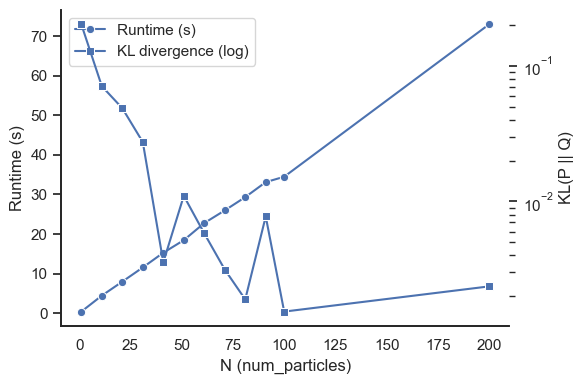

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows = []
for N, (runtime, kl_div, dist) in stats.items():
    rows.append({"N": N, "runtime": runtime, "kl_div": kl_div})

df = pd.DataFrame(rows).sort_values("N")

plt.rcParams.update({
    "font.family": "Times New Roman",
    "axes.unicode_minus": False,
})

sns.set_theme(style="white")

fig, ax1 = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=df,
    x="N",
    y="runtime",
    marker="o",
    ax=ax1,
    legend=False,
)
ax1.set_xlabel("N (num_particles)")
ax1.set_ylabel("Runtime (s)")

ax2 = ax1.twinx()
sns.lineplot(
    data=df,
    x="N",
    y="kl_div",
    marker="s",
    ax=ax2,
    legend=False,
)
ax2.set_ylabel("KL(P || Q)")
ax2.set_yscale("log")

ax1.grid(False)
ax2.grid(False)

for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)

line1 = ax1.lines[0]
line2 = ax2.lines[0]
ax1.legend(
    [line1, line2],
    ["Runtime (s)", "KL divergence (log)"],
    loc="best",
)

plt.tight_layout()
plt.show()
